# Simple Twitter Analysis

By: Atwine Mugume Twinamatsiko

In [1]:
#import the necessary libraries
import tweepy
import json
import time

#let's try to read this data with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#this will help us to work with the streaming API
import slistener as sl

#consumer key, consumer secret, access token, access secret.
ckey="tLolJ53qD8C7MzxWOynytE7Wr"
csecret="k7XtFldKsnWwY85FAUE1BMrmKFSQT9ZvIsxWLhXdnRmiZ8H2LY"
atoken="2400788581-SqJ2TljEPI7GEKZa67AoDPGUZr3DqEUJ7cBp5Ng"
asecret="tnPy4kKayWeIZt6lN1iCY1C1cnzC7PKrlTSJXAD1iXvIX"

# Instantiating objects of authentication 
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

In [2]:
# Creation of the actual interface, using authentication
api = tweepy.API(auth)

# Reading the Data

In [3]:
# Where you put the data of twitter stream
tweets_data_path = 'data.json'

In [4]:
# this function will help us flatten the tweets so that we will be able to get
# the extended tweet versions of the text.
def flatten_tweets(tweets_file):
    """ Flattens out tweet dictionaries so relevant JSON
        is in a top-level dictionary."""
    
    tweets_json = open( tweets_file, "r")
    
    tweets_list = []
    
    # Iterate through each tweet
    for tweet in tweets_json:
        tweet_obj = json.loads(tweet)
    
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
            
        tweets_list.append(tweet_obj)
    return tweets_list

In [5]:
tweets = flatten_tweets(tweets_data_path)

In [6]:
# Create a DataFrame from `tweets`
ds_tweets = pd.DataFrame(tweets)

# Print out the first 5 tweets from this dataset
print(ds_tweets['text'].values[0:5])

['RT @OleItumbi: UGANDAN President @KagutaMuseveni\nshows the country how to exercise at home in bid to discourage evening walks #StayAtHome #…'
 'RT @nbstv: Ugandan citizen Samuel Kimbowa who fetches water for a living donated UGX5000 to aid the government in the fight against #COVID1…'
 'I hereby challenge Presidents Uhuru, Kagame, Nkurunziza, Kiir and Magufuri to the #WorkoutFromHome challenge East A… https://t.co/rdCrUAPkQ5'
 'RT @KM_thoni: Not only is he coming for daily TV presenters, now fitness influencers need to watch out too.\n\nAnyway, please stay in your ho…'
 '@KagutaMuseveni A President with a personality\nFeeling very inspired to stay home #COVID19UG']


In [7]:
ds_tweets.shape

(885, 40)

In [8]:
ds_tweets[['text']]

,text
0,RT @OleItumbi: UGANDAN President @KagutaMuseve...
1,RT @nbstv: Ugandan citizen Samuel Kimbowa who ...
2,"I hereby challenge Presidents Uhuru, Kagame, N..."
3,RT @KM_thoni: Not only is he coming for daily ...
4,@KagutaMuseveni A President with a personality...
...,...
880,RT @nbstv: Ugandan citizen Samuel Kimbowa who ...
881,RT @AKasingye: Tell Tugume ngu akanyanga. She ...
882,The hairstyle is scary in these trying times 😷😥
883,"RT @newvisionwire: QUOTE OF THE DAY\n\n""God ca..."


In [9]:
#since I have collected some of the data that is general.
#I would like to know how many times the tweet is related to corona
count_corona = ds_tweets['text'].str.contains('#corona', case = False)

#let's find the parcentage
print("The total % corona is talked about is: ",(round(sum(count_corona)/ds_tweets.shape[0]*100)),"%")

The total % corona is talked about is:  2 %


Recall that relevant text may not only be in the main text field of the tweet. It may also be in the `extended_tweet`, the `retweeted_status`, or the `quoted_status`. We need to check all of these fields to make sure we've accounted for all the of the relevant text. We'll do this often so we're going to create a function which does this.

### Function here below.

In [10]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet'].str.contains(word, case = False) 
     #contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False) 
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False) 
     #contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

In [11]:
sum(check_word_in_tweet('corona',ds_tweets))/ds_tweets.shape[0]*100 +\
sum(check_word_in_tweet('#corona',ds_tweets))/ds_tweets.shape[0]*100

#this tells us that out of the total 899 tweets only about 10% are related 
#to corona virus, I dont think this could be the case for a country like Italy.


9.830508474576272

In [12]:
# time analysis

In [13]:
ds_tweets.head(1)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,lang,timestamp_ms,user-screen_name,retweeted_status-user-screen_name,retweeted_status-text,extended_tweet,extended_tweet-full_text,possibly_sensitive,extended_entities,display_text_range
0,Thu Apr 09 15:22:18 +0000 2020,1248270016480448512,1248270016480448512,RT @OleItumbi: UGANDAN President @KagutaMuseve...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,...,en,1586445738321,BrianRop17,OleItumbi,UGANDAN President @KagutaMuseveni\nshows the c...,NaN,NaN,NaN,NaN,NaN


In [14]:
#change the date to a datetime variable
ds_tweets['created_at'] = pd.to_datetime(ds_tweets['created_at'])

#change the index of the whole dataset

ds_tweets.set_index('created_at',inplace= True)

In [15]:
#let's resample over a time of 5 minutes
#this means we shall use the resample method on the datetime column
#it will help us count over time the prevalence of the word.

ds_tweets['corona'] = check_word_in_tweet('corona',ds_tweets)

mean_corona = ds_tweets['corona'].resample('10 min').mean()
#we use resample to measure means over the total 5 min windows
#it will show us for every 5 mins when do people talk about corona


In [16]:
#let's have a look.
mean_corona.head(3)

created_at
2020-04-09 15:20:00+00:00    0.085106
2020-04-09 15:30:00+00:00    0.058824
2020-04-09 15:40:00+00:00    0.065217
Freq: 10T, Name: corona, dtype: float64

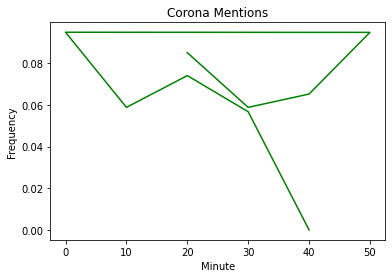

In [17]:
#let's plot the sequence

plt.plot(mean_corona.index.minute, 
    mean_corona, color = 'green')
plt.xlabel('Minute')
plt.ylabel('Frequency')
plt.title('Corona Mentions')
plt.show()

### Sentiment Analysis.

In [18]:
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = ds_tweets['text'].apply(sid.polarity_scores)

In [19]:
#checking what is in these datastructures
sentiment_scores[:5][0]

{'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'compound': -0.4215}

In [20]:
#create the sentiment object
sentiment = sentiment_scores.apply(lambda x: x['compound'])

In [21]:
# Print out the text of a positive tweet
print(ds_tweets[sentiment > 0.6]['text'].values[0])

print('\n')
# Print out the text of a negative tweet
print(ds_tweets[sentiment < -0.6]['text'].values[0])

# Generate average sentiment scores for #python
sentiment_py = sentiment[ check_word_in_tweet('corona', ds_tweets) ].resample('20 m').mean()

# Generate average sentiment scores for #rstats
sentiment_r = sentiment[ check_word_in_tweet('corona', ds_tweets) ].resample('20 m').mean()

@KagutaMuseveni A President with a personality
Feeling very inspired to stay home #COVID19UG


RT @ntvuganda: JUST IN: @PoliceUg in Kireka has impounded a @MinofHealthUG van for violating the emergency health guidelines specifically s…


In [22]:
#this will change when we have more data.
sentiment_py

created_at
2020-04-30 00:00:00+00:00   -0.075342
Freq: 20M, Name: text, dtype: float64

In [ ]:
#I  need more data to work with in order for the graph below to make sense, it only has
#a median value for one day so not much comparison is done

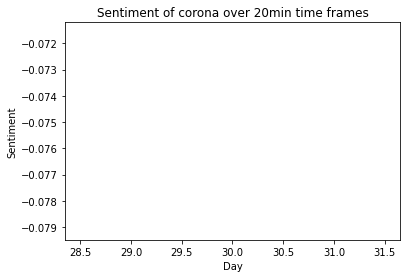

In [23]:
# Plot average #python sentiment per day
plt.plot(sentiment_py.index.day, sentiment_py, color = 'green')

plt.xlabel('Day')
plt.ylabel('Sentiment')
plt.title('Sentiment of corona over 20min time frames')
plt.show()

### Twitter Networks

In [24]:
sotu_retweets = ds_tweets[['user-screen_name','retweeted_status-user-screen_name']]

In [25]:
#import the necessary library
import networkx as nx

In [26]:
# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(
    sotu_retweets,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 830
Edges in RT network: 812


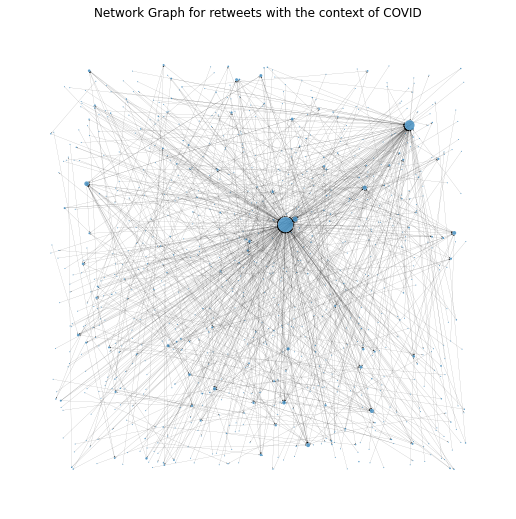

In [27]:
# Create random layout positions
plt.figure(figsize= (9,9))
plt.title('Network Graph for retweets with the context of COVID')
pos = nx.random_layout(G_rt)

# Create size list
sizes = [x[1] for x in G_rt.degree()]

# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

#we can see that there are some major players in these retweet graphs.
#we can make more sense of this in a way that we can see who the big players are
#what they are talking about in this time.


In [28]:
#Individual-level network metrics
#who are the most important nodes in this network.
#betweeness centrality: who is the pivot of the discussion in this time?
#in degree high centrality: who is being retweeted the most.
#out degree high centrality: someone who retweets a lot.
#replies high: means someone who gets a lot of replies
#replies high outdegree: replies people a lot

<img src = 'twitter networks.png'>

In [29]:
column_names = ['screen_name', 'degree_centrality']
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())

#we can see that nbstv has a high degree of centrality in retweets
#meaning people are getting their information from NBSTV

       screen_name  degree_centrality
5              NaN           0.275030
3            nbstv           0.118215
38   MinofHealthUG           0.030157
163       SKigaani           0.019300
46        edthnaka           0.018094


In [30]:
#betweeness centrality
#who is the person that is the most important: like a middle person of communication
column_namez = ['screen_name', 'betweenness_centrality']

In [31]:
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_namez)

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

         screen_name  betweenness_centrality
188       RwenzoriUg                0.000178
3              nbstv                0.000131
203  centurybottling                0.000093
18   AsantejnrRuhima                0.000058
119          skaheru                0.000041


### Bag of Words

In [32]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [33]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
#take out the text information that I need 
dt = ds_tweets[['text']]

In [39]:
dt.head(3)

,text
created_at,
2020-04-09 15:22:18+00:00,RT @OleItumbi: UGANDAN President @KagutaMuseve...
2020-04-09 15:22:22+00:00,RT @nbstv: Ugandan citizen Samuel Kimbowa who ...
2020-04-09 15:22:23+00:00,"I hereby challenge Presidents Uhuru, Kagame, N..."


In [40]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))



#lets count the number of words in each tweet
dt['word_count'] = dt['text'].apply(lambda x: len(str(x).split(" ")))
dt['char_count'] = dt['text'].str.len() ## this also includes spaces
dt['avg_word'] = dt['text'].apply(lambda x: avg_word(x))#average number of words
dt['stopwords'] = dt['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
dt['hashtags'] = dt['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
dt['numerics'] = dt['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
dt[['text','word_count','char_count','avg_word','stopwords','hashtags','numerics']].head()

,text,word_count,char_count,avg_word,stopwords,hashtags,numerics
created_at,,,,,,,
2020-04-09 15:22:18+00:00,RT @OleItumbi: UGANDAN President @KagutaMuseve...,20,140,5.714286,6,2,0
2020-04-09 15:22:22+00:00,RT @nbstv: Ugandan citizen Samuel Kimbowa who ...,23,140,5.130435,8,1,0
2020-04-09 15:22:23+00:00,"I hereby challenge Presidents Uhuru, Kagame, N...",17,140,7.294118,3,1,0
2020-04-09 15:22:29+00:00,RT @KM_thoni: Not only is he coming for daily ...,24,140,4.600000,9,0,0
2020-04-09 15:22:35+00:00,@KagutaMuseveni A President with a personality...,12,92,6.153846,4,1,0


In [180]:
#preprocessing: turn our tweet into small letters

In [41]:
dt['text'] = dt['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [42]:
dt[['text']].head(3)

,text
created_at,
2020-04-09 15:22:18+00:00,rt @oleitumbi: ugandan president @kagutamuseve...
2020-04-09 15:22:22+00:00,rt @nbstv: ugandan citizen samuel kimbowa who ...
2020-04-09 15:22:23+00:00,"i hereby challenge presidents uhuru, kagame, n..."


In [43]:
#removing punctuations

In [44]:
dt['text'] = dt['text'].str.replace('[^\w\s]','')
dt[['text']].head(3)

,text
created_at,
2020-04-09 15:22:18+00:00,rt oleitumbi ugandan president kagutamuseveni ...
2020-04-09 15:22:22+00:00,rt nbstv ugandan citizen samuel kimbowa who fe...
2020-04-09 15:22:23+00:00,i hereby challenge presidents uhuru kagame nku...


In [45]:
#remove stop words

In [46]:
dt['text'] = dt['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dt[['text']].head(3)

,text
created_at,
2020-04-09 15:22:18+00:00,rt oleitumbi ugandan president kagutamuseveni ...
2020-04-09 15:22:22+00:00,rt nbstv ugandan citizen samuel kimbowa fetche...
2020-04-09 15:22:23+00:00,hereby challenge presidents uhuru kagame nkuru...


Common word removal
Previously, we just removed commonly occurring words in a general sense. We can also remove commonly occurring words from our text data First, let’s check the 10 most frequently occurring words in our text data then take call to remove or retain.

Now, let’s remove these words as their presence will not of any use in classification of our text data.

Rare words removal
Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. Because they’re so rare, the association between them and other words is dominated by noise. You can replace rare words with a more general form and then this will have higher counts

In [47]:
freq = pd.Series(' '.join(dt['text']).split()).value_counts()[-10:]
freq

en                    1
prays                 1
httpstcoq6n2viz0o6    1
httpstcoep5arsliec    1
pablo                 1
httpstcoaiskdrdavg    1
claims                1
visituganda           1
bulungi               1
rugusuki              1
dtype: int64

In [48]:
freq = list(freq.index)
dt['text'] = dt['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dt['text'].head()

created_at
2020-04-09 15:22:18+00:00    rt oleitumbi ugandan president kagutamuseveni ...
2020-04-09 15:22:22+00:00    rt nbstv ugandan citizen samuel kimbowa fetche...
2020-04-09 15:22:23+00:00    hereby challenge presidents uhuru kagame nkuru...
2020-04-09 15:22:29+00:00    rt km_thoni coming daily tv presenters fitness...
2020-04-09 15:22:35+00:00    kagutamuseveni president personality feeling i...
Name: text, dtype: object

#### Tokenization
Tokenization refers to dividing the text into a sequence of words or sentences. In our example, we have used the textblob library to first transform our tweets into a blob and then converted them into a series of words.

In [55]:
from textblob import TextBlob
dt['words'] = dt['text'].apply(lambda x: TextBlob(x).words)

In [56]:
dt['words']

created_at
2020-04-09 15:22:18+00:00    [rt, oleitumbi, ugandan, president, kagutamuse...
2020-04-09 15:22:22+00:00    [rt, nbstv, ugandan, citizen, samuel, kimbowa,...
2020-04-09 15:22:23+00:00    [hereby, challenge, presidents, uhuru, kagame,...
2020-04-09 15:22:29+00:00    [rt, km_thoni, coming, daily, tv, presenters, ...
2020-04-09 15:22:35+00:00    [kagutamuseveni, president, personality, feeli...
                                                   ...                        
2020-04-09 16:39:55+00:00    [rt, nbstv, ugandan, citizen, samuel, kimbowa,...
2020-04-09 16:39:59+00:00    [rt, akasingye, tell, tugume, ngu, akanyanga, ...
2020-04-09 16:40:02+00:00                    [hairstyle, scary, trying, times]
2020-04-09 16:40:09+00:00    [rt, newvisionwire, quote, day, god, cares, ev...
2020-04-09 16:40:12+00:00    [work, home, yes, sevo, another, pressup, yes,...
Name: words, Length: 885, dtype: object

### Lemmatization
Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.

In [57]:
#nltk.download('wordnet')

In [61]:
from textblob import Word
dt['text'] = dt['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [62]:
dt.text

created_at
2020-04-09 15:22:18+00:00    rt oleitumbi ugandan president kagutamuseveni ...
2020-04-09 15:22:22+00:00    rt nbstv ugandan citizen samuel kimbowa fetch ...
2020-04-09 15:22:23+00:00    hereby challenge president uhuru kagame nkurun...
2020-04-09 15:22:29+00:00    rt km_thoni coming daily tv presenter fitness ...
2020-04-09 15:22:35+00:00    kagutamuseveni president personality feeling i...
                                                   ...                        
2020-04-09 16:39:55+00:00    rt nbstv ugandan citizen samuel kimbowa fetch ...
2020-04-09 16:39:59+00:00    rt akasingye tell tugume ngu akanyanga know sh...
2020-04-09 16:40:02+00:00                          hairstyle scary trying time
2020-04-09 16:40:09+00:00    rt newvisionwire quote day god care every area...
2020-04-09 16:40:12+00:00    work home yes sevo another pressup yes sevo co...
Name: text, Length: 885, dtype: object

### Bag of words

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(dt['text'])
train_bow

<885x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 8423 stored elements in Compressed Sparse Row format>

In [71]:
#install wordcloud to help with the visualizations.
from wordcloud import WordCloud

In [69]:
def gen_freq(text):
    
    #List of words
    word_list = []
    
    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)
    
    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    #Print top 20 words
    word_freq[:20]
    
    return word_freq

In [70]:
gen_freq(dt.text.str)

rt            619
uganda        149
friend        123
covid19ug     121
tell          121
             ... 
winning         1
tyrannical      1
fe              1
puede           1
class           1
Length: 2580, dtype: int64

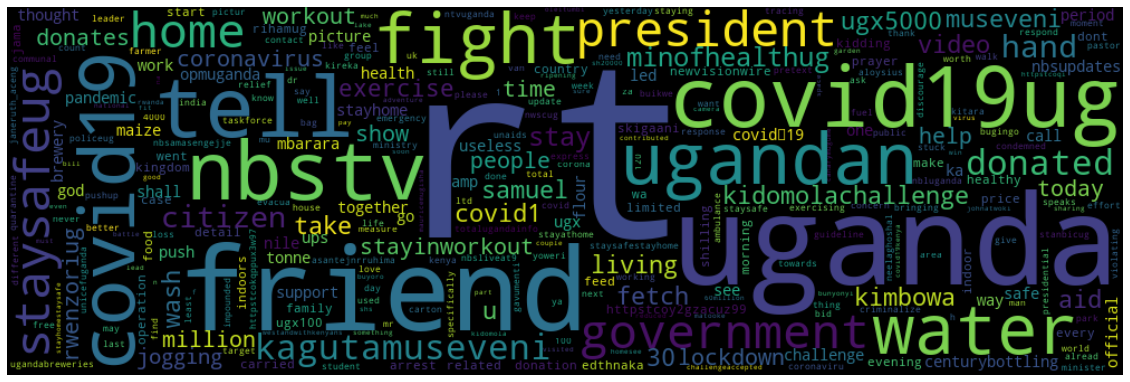

In [73]:
word_freq = gen_freq(dt.text.str)

#Generate word cloud
wc = WordCloud(width=1000, height=330, max_words=300, background_color='black').generate_from_frequencies(word_freq)

plt.figure(figsize=(20, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Notes:-

I need to remove some of the words that are redundant,  I can see many words but I would like for them to relate to health more than some random things. 

It would make so much sense if we are to see covid related terms in the word cloud.

We can also draw word frequencies and other things to properly represent how the trend is moving.

This is a link to look at tomorrow: https://www.machinelearningplus.com/category/nlp/

I also need to find a way to remove a lot of the useless words so that they won't appear in my word cloud. I only need health related values there not funny things. I can even see a website as of now.

I should look more into networks and how to represent them better...

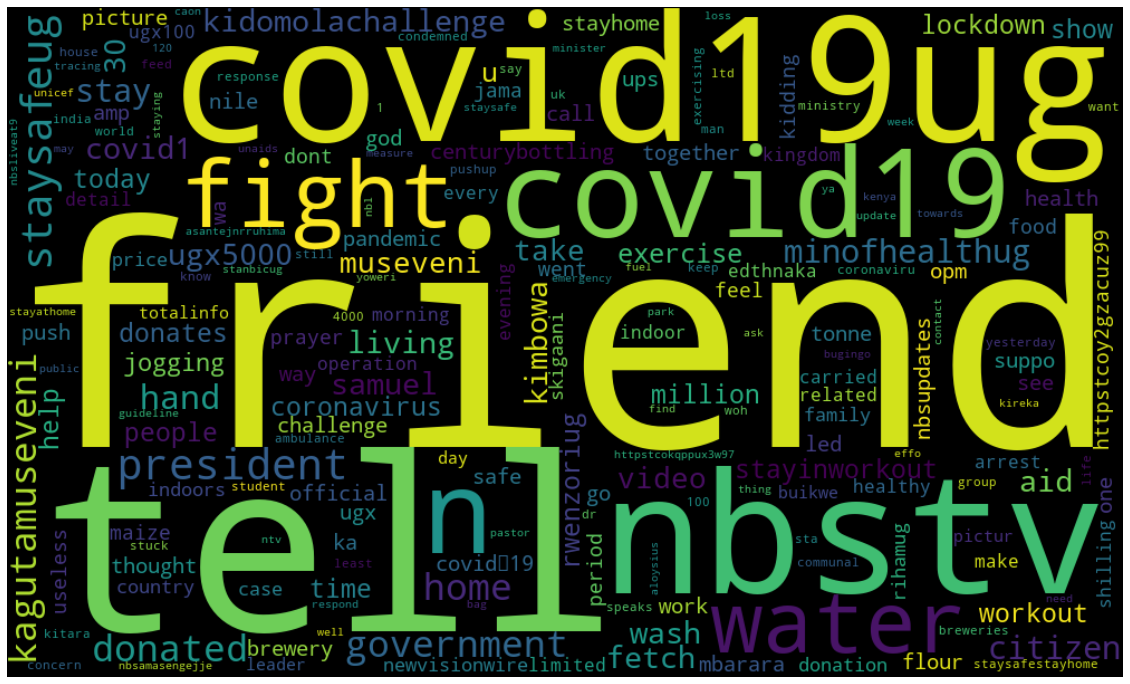

In [79]:
#Import re and list of stopwards
import re
from wordcloud import STOPWORDS

def clean_text(text):
    #Remove RT
    text = re.sub(r'RT', '', text)
    text = re.sub(r'rt', "", text)
    text = re.sub(r'uganda', '',text)
    
    #Fix &
    text = re.sub(r'&amp;', '&', text)
    
    #Remove punctuations
    text = re.sub(r'[?!.;:,#@-]', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
    
    return text

text = dt.text.apply(lambda x: clean_text(x))
word_freq = gen_freq(text.str)*100
word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')

#Generate word cloud
wc = WordCloud(width=1000, height=600, max_words=200, background_color='black').generate_from_frequencies(word_freq)

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Trying to collect historical data

In [ ]:
# Initializing a listener class that streams Twitter status
class StdOutListener(tweepy.StreamListener):
#     Create an init statement
    def __init__(self, start_time, time_limit=100):
        self.time = start_time
        self.limit = time_limit
        self.tweet_data = []
    
#     Defining what you are going to do based on data
    def on_data(self, data):
        try:
#             Opening data for streaming
            with open('output.json', 'a') as f:
                f.write(data)
                return True
        except KeyboardInterrupt:
            print("Twitter Download is interrupted")
        except BaseException as e:
            print(str(e))
        return True

    def on_error(self, status):
        print (status)

In [ ]:
#This handles Twitter authetification and the connection to Twitter Streaming API
keywords_to_track = ['#Covid19UG','#Uganda','#STAYSAFEUG']
start_time = time.strptime("7 Apr 20", "%d %b %y")    
l = StdOutListener(start_time)
strm = tweepy.Stream(auth, l)
# Begin collecting data
strm.filter(track = keywords_to_track)